In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.integrate import solve_ivp

rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', labelsize=20)
rc("axes", linewidth=1)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
rc('legend', fontsize=20)
rc('ytick', right='True',direction= 'in')
rc('xtick', top='True',direction= 'in')
rc('xtick.major', pad=15)
rc('ytick.major', pad=15)
rc('xtick.major', size=12)
rc('ytick.major', size=12)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)

# Stellar structure in general relativity

The TOV equations describing the structure of a spherically symmetric star in GR:
\begin{align}
    \frac{dm}{dr} &= 4\pi r^2\rho \\
    \frac{dP}{dr} &=-\frac{m\rho}{r^2}\left[1+\frac{P}{\rho}\right]\left[1+\frac{4\pi r^3P}{m}\right]\left[1-\frac{2m}{r}\right]^{-1}\\
    \frac{d\Phi}{dr} &= \frac{4\pi P r^3+m}{r(r-2m)}
\end{align}
Equation of state used:
\begin{equation}
    P(\rho) = K\rho^{5/3}[1-(\rho_0/\rho)^{1/3}]
\end{equation}

__Prob 1__: I have not included it here since it is already solved by Arif on MATHEMATICA in the tutorial session

__Prob 2__: In the exterior region of the star, $\rho(r) = p(r) = 0$ for all $r>R$. We then have,
\begin{align}
    \frac{dm}{dr} &= 0 \\
    \frac{d\Phi}{dr} &= \frac{M}{r(r-2M)}
\end{align}
Solving the above equations we get, 
\begin{equation}
    e^{2\Phi(r)} = 1-\frac{2M}{r}
\end{equation}
If we now plug this in the metric for the spherically symmetric and static spacetime we get
\begin{align}
    ds^2 & = -e^{2\Phi} dt^2 + e^{2\Lambda}dr^2+r^2 d\Omega^2\\
    \implies ds^2 &=-\left(1-\frac{2M}{r}\right)dt^2+\left(1-\frac{2M}{r}\right)^{-1}dr^2+r^2d\Omega^2
\end{align}
which is the required exterior Schwarzschild metric

__Prob 3__: Here we solve the TOV equations numerically with a given EOS

In [99]:
#Defining the constants in CGS units
mu_e = 2.
K = 1e13*pow(mu_e,-5./3.)
Z = 6
rho_0 = 0.4*Z*Z*mu_e

G = 6.674e-8
c = 3e10
Msun = 2e33
Rsun = 6.957e10

In [108]:
def p_rho(rh): #EOS
    return K*pow(rh,4./3.)*(1-pow(rho_0/rh,1./3.))

def dp_drho(rh): #using the EOS
    return (K/3.)*(5*pow(rh,2./3.)*(1-pow(rho_0/rh,1./3.))+pow(rh*rho_0,1./3.))
    
def TOV1(r, y):
    m, rho= y
    dm_dr = 4*np.pi*r**2*rho #mass equation
    drho_dr = (-G*m*rho/(r**2))*(1+p_rho(rho)/(c**2*rho))*(1+4.*np.pi*r**3*p_rho(rho)/(c**2*m))/(dp_drho(rho)*(1-2.*G*m/(c**2*r)))
    return[dm_dr, drho_dr]

def TOV2(r,m,p):
    dphi_dr = (G/c**2)*(m+4.*np.pi*p*r**3/c**2)/(r*(r-2.*G*m/c**2))
    return dphi_dr

In [109]:
def term_cond(r, y): #termination condition : rho = rho_0
    return y[1]-rho_0
term_cond.terminal = True

In [126]:
rho_c = np.logspace(6,14,9) #central densities
sol = []
for rc in rho_c:
    y0 = [1e-12,rc] #initial condition y0[0] = m[0],y0[1] = rho_c
    sol.append(solve_ivp(TOV1, [1e-10, 1e15], y0=y0 ,method = 'RK45', dense_output=True,events=term_cond))
    
mass, density, pressure, radius, phi = [],[],[],[],[] #arrays to store the stellar structure quantities
#Solving TOV1
for i in range(len(sol)):
    radius.append(sol[i].t)
    mass.append(sol[i].y[0])
    rr = sol[i].y[1]
    density.append(rr)
    pp = []
    for rh in rr:
        pp.append(p_rho(rh))
    pressure.append(pp)
#Solving TOV2   
Rstar, Mstar = np.zeros(len(sol)), np.zeros(len(sol))
for i in range(len(sol)):
    Rstar[i] = radius[i][-1]
    Mstar[i] = mass[i][-1]
    phi_R = 0.5*np.log(1-2.*G*Mstar[i]/(c**2*Rstar[i]))
    ph = np.zeros(len(radius[i]))
    ph[-1] = phi_R
    N = len(radius[i])
    for j in range(1,N):
        delr = radius[i][N-j-1]-radius[i][N-j]
        delphi = TOV2(radius[i][N-j], mass[i][N-j], pressure[i][N-j])*delr
        phi_R += delphi
        ph[N-j] = phi_R
    phi.append(ph)

<ipython-input-108-16b28504d4df>:2: RuntimeWarning: invalid value encountered in double_scalars
  return K*pow(rh,4./3.)*(1-pow(rho_0/rh,1./3.))
<ipython-input-108-16b28504d4df>:5: RuntimeWarning: invalid value encountered in double_scalars
  return (K/3.)*(5*pow(rh,2./3.)*(1-pow(rho_0/rh,1./3.))+pow(rh*rho_0,1./3.))


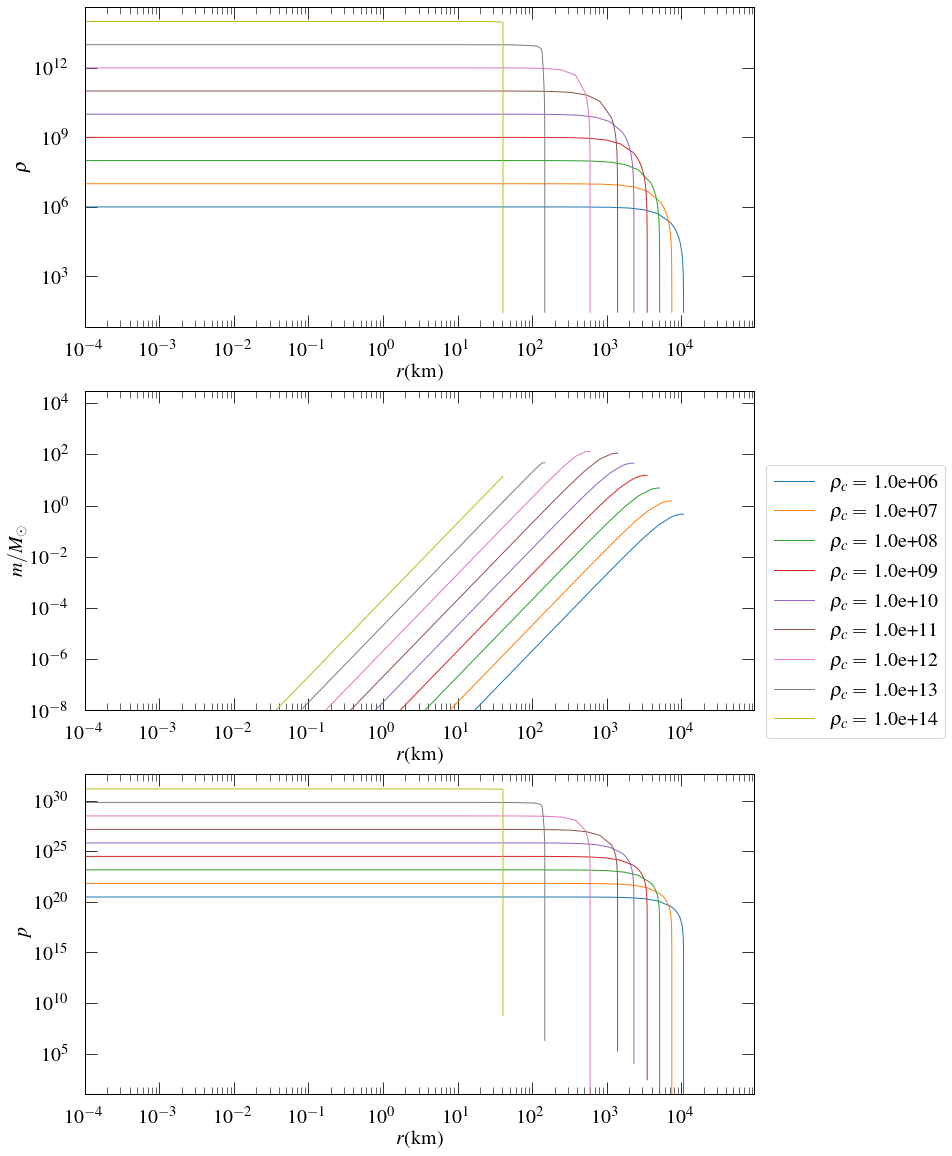

In [103]:
plt.figure(figsize = (12,20))
plt.subplot(3,1,1)
for i in range(len(sol)):
    plt.loglog(radius[i]/10**5,density[i],label=r'$\rho_c =$ %3.1e'%rho_c[i])
plt.ylabel(r'$\rho$')
plt.xlabel(r'$r$(km)')
plt.xlim(left = 1e-4)

plt.subplot(3,1,2)
for i in range(len(sol)):
    plt.loglog(radius[i]/10**5,mass[i]/Msun,label=r'$\rho_c =$ %3.1e'%rho_c[i])
plt.ylabel(r'$m/M_\odot$')
plt.xlabel(r'$r$(km)')
plt.xlim(left = 1e-4)
plt.ylim(bottom = 1e-8)

plt.subplot(3,1,3)
for i in range(len(sol)):
    plt.loglog(radius[i]/10**5,pressure[i],label=r'$\rho_c =$ %3.1e'%rho_c[i])
plt.ylabel(r'$p$')
plt.xlabel(r'$r$(km)')
plt.xlim(left = 1e-4)

plt.legend(bbox_to_anchor=(1.3, 2.))
plt.show()